In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.axes import Axes as ax

import sklearn
from sklearn.model_selection import train_test_split

In [2]:
# Display data for easy reference 

fifa = pd.read_csv('/work/players_fifa23.csv')
fifa.head() 
fifa['test'] = fifa['Overall'] - fifa['Potential']
fifa

ID            Name            FullName  Age  Height  Weight  \
0      158023        L. Messi        Lionel Messi   35     169      67   
1      165153      K. Benzema       Karim Benzema   34     185      81   
2      188545  R. Lewandowski  Robert Lewandowski   33     185      81   
3      192985    K. De Bruyne     Kevin De Bruyne   31     181      70   
4      231747       K. Mbappé       Kylian Mbappé   23     182      73   
...       ...             ...                 ...  ...     ...     ...   
18534  243725      D. Collins      Darren Collins   21     174      68   
18535  261933    Yang Dejiang        Dejiang Yang   17     175      60   
18536  267823       L. Mullan         Liam Mullan   18     170      65   
18537  267824    D. McCallion    Daithí McCallion   17     178      65   
18538  261424        N. Rabha         Nabin Rabha   25     176      66   

                                               PhotoUrl          Nationality  \
0      https://cdn.sofifa.net/players/158/023/23_60.png            Argentina   
1      https://cdn.sofifa.net/players/165/153/23_60.png               France   
2      https://cdn.sofifa.net/players/188/545/23_60.png               Poland   
3      https://cdn.sofifa.net/players/192/985/23_60.png              Belgium   
4      https://cdn.sofifa.net/players/231/747/23_60.png               France   
...                                                 ...                  ...   
18534  https://cdn.sofifa.net/players/243/725/23_60.png  Republic of Ireland   
18535  https://cdn.sofifa.net/players/261/933/23_60.png             China PR   
18536  https://cdn.sofifa.net/players/267/823/23_60.png     Northern Ireland   
18537  https://cdn.sofifa.net/players/267/824/23_60.png  Republic of Ireland   
18538  https://cdn.sofifa.net/players/261/424/23_60.png                India   

       Overall  Potential  ...  CMRating  RMRating  LWBRating CDMRating  \
0           91         91  ...        88        91         67        66   
1           91         91  ...        84        89         67        67   
2           91         91  ...        83        86         67        69   
3           91         91  ...        91        91         82        82   
4           91         95  ...        84        92         70        66   
...        ...        ...  ...       ...       ...        ...       ...   
18534       47         56  ...        44        50         41        38   
18535       47         57  ...        45        45         47        48   
18536       47         67  ...        49        52         46        44   
18537       47         61  ...        33        33         44        42   
18538       47         50  ...        40        44         46        43   

      RWBRating LBRating  CBRating  RBRating  GKRating test  
0            67       62        53        62        22    0  
1            67       63        58        63        21    0  
2            67       64        63        64        22    0  
3            82       78        72        78        24    0  
4            70       66        57        66        21   -4  
...         ...      ...       ...       ...       ...  ...  
18534        41       40        36        40        15   -9  
18535        47       49        49        49        15  -10  
18536        46       46        42        46        17  -20  
18537        44       47        49        47        15  -14  
18538        46       47        47        47        19   -3  

[18539 rows x 91 columns]

In [3]:
from sklearn.preprocessing import MinMaxScaler
# Replace missing values (NaN) with column mean; drop rows where value/wage/releaseClause info are unavailable  

fifa['Age'].fillna(fifa['Age'].mean(), inplace = True)
fifa['Height'].fillna(fifa['Height'].mean(), inplace = True)
fifa['Weight'].fillna(fifa['Weight'].mean(), inplace = True)
fifa['ValueEUR'].fillna(fifa['ValueEUR'].mean(), inplace = True)
fifa['WageEUR'].fillna(fifa['WageEUR'].mean(), inplace = True)
fifa['ReleaseClause'].fillna(fifa['ReleaseClause'].mean(), inplace = True)

fifa = fifa.drop(fifa[fifa['ValueEUR']==0].index,axis=0)
fifa = fifa.drop(fifa[fifa['ReleaseClause']==0].index,axis=0)
fifa = fifa.drop(fifa[fifa['WageEUR']==0].index,axis=0)

# Clean and organize 'age' column into <30 and > 30

def under_30(df):
    return (df['Age']<30)
temp = pd.get_dummies(under_30(fifa))
fifa['under_30'],fifa['above_30'] = temp.iloc[:,1],temp.iloc[:,0]

fifa['Age under 30'] = fifa['under_30']*fifa['Age']
fifa['Age above 30'] = fifa['above_30']*fifa['Age']

# Clean dataset, create new column 'ContractLen' to replace two redundant columns

def contract_len(df):
    return df['ContractUntil']-df['ClubJoined']
fifa['ContractLen'] = contract_len(fifa)

# Replace player attributes with log values as well as using other forms of transformation

fifa['log ShootingTotal'] = np.log(fifa['ShootingTotal'])
fifa['log PassingTotal'] = np.log(fifa['PassingTotal'])
fifa['log DribblingTotal'] = np.log(fifa['DribblingTotal'])
fifa['log DefendingTotal'] = np.log(fifa['DefendingTotal'])

fifa['log HeadingAccuracy'] = np.log(fifa['HeadingAccuracy'])
fifa['log Acceleration'] = np.log(fifa['Acceleration'])
fifa['log Strength'] = np.log(fifa['Strength'])
fifa['log Positioning'] = np.log(fifa['Positioning'])

fifa['log Overall'] = np.log(fifa['Overall']) * 2 
fifa['log BaseStats'] = np.log(fifa['BaseStats'])  
fifa['log Reactions'] = np.log(fifa['Reactions'])
fifa['log Potential'] = np.log(fifa['Potential'])
fifa['augmented IntReputation'] = fifa['IntReputation'] * 7

fifa['log ReleaseClause'] = np.log(fifa['ReleaseClause'])  * 2.5
fifa['log ValueEUR'] = np.log(fifa['ValueEUR']) * 2.5
fifa['log Age under 30'] = MinMaxScaler().fit_transform(np.array(fifa['Age under 30']).reshape(-1,1))
fifa['log Age above 30'] = MinMaxScaler().fit_transform(np.array(fifa['Age above 30']).reshape(-1,1))

In [4]:
# Finally, clean the dataset, select necessary columns, and get ready to put them into the model

df = pd.get_dummies(fifa[['WageEUR', 'log ValueEUR', 'log ReleaseClause','augmented IntReputation', 
'log Overall', 'log BaseStats', 'log Potential', 'log Reactions',
'log HeadingAccuracy', 'log Acceleration','log Strength', 'log Positioning',
'log ShootingTotal','log PassingTotal', 'log DribblingTotal', 'log DefendingTotal',
'log Age under 30', 'log Age above 30'
]])

df.head()

WageEUR  log ValueEUR  log ReleaseClause  augmented IntReputation  \
0   195000     44.511237          46.049201                       35   
1   450000     44.935984          46.730584                       28   
2   420000     45.615818          47.410418                       35   
3   350000     46.232504          47.770782                       28   
4   230000     47.662907          49.300137                       28   

   log Overall  log BaseStats  log Potential  log Reactions  \
0     9.021719       6.113682       4.510860       4.521789   
1     9.021719       6.120297       4.510860       4.521789   
2     9.021719       6.126869       4.510860       4.532599   
3     9.021719       6.180017       4.510860       4.510860   
4     9.021719       6.152733       4.553877       4.532599   

   log HeadingAccuracy  log Acceleration  log Strength  log Positioning  \
0             4.248495          4.465908      4.219508         4.532599   
1             4.499810          4.369448      4.406719         4.521789   
2             4.510860          4.330733      4.465908         4.543295   
3             4.007333          4.330733      4.304065         4.477337   
4             4.276666          4.574711      4.330733         4.521789   

   log ShootingTotal  log PassingTotal  log DribblingTotal  \
0           4.488636          4.499810            4.543295   
1           4.477337          4.418841            4.465908   
2           4.510860          4.369448            4.454347   
3           4.477337          4.532599            4.465908   
4           4.488636          4.382027            4.521789   

   log DefendingTotal  log Age under 30  log Age above 30  
0            3.526361          0.000000          0.795455  
1            3.663562          0.000000          0.772727  
2            3.784190          0.000000          0.750000  
3            4.158883          0.000000          0.704545  
4            3.583519          0.793103          0.000000

In [5]:
DeepnoteChart(df, """{"mark":{"type":"bar","tooltip":true},"width":"container","height":"container","$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{"x":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear"}},"y":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear"}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear"}}}}""")

In [6]:
columns = df.columns
corr_list = []
column_needed = []
column_needed_2 = []
#y = fifa['WageEUR']
for col in columns:
    for col2 in columns:
        #if type(df[col][0]) == np.int64:
        corr = np.corrcoef(df[col],df[col2])
        corr_list.append(np.round(corr[0][1], 3))
        column_needed.append(col)
        column_needed_2.append(col2)
data = {"Column": column_needed, "Column2": column_needed_2, "Correlation Score": corr_list}
correlation_score = pd.DataFrame(data)
correlation_score = correlation_score[correlation_score['Correlation Score'] != 1.0]
correlation_score = correlation_score[correlation_score['Correlation Score'] > 0.7]
correlation_score.sort_values(by=['Correlation Score'], ascending=False)

Column              Column2  Correlation Score
20          log ValueEUR    log ReleaseClause              0.990
37     log ReleaseClause         log ValueEUR              0.990
73           log Overall         log ValueEUR              0.872
22          log ValueEUR          log Overall              0.872
110        log Potential    log ReleaseClause              0.871
42     log ReleaseClause        log Potential              0.871
130        log Reactions          log Overall              0.857
79           log Overall        log Reactions              0.857
239     log PassingTotal        log BaseStats              0.847
103        log BaseStats     log PassingTotal              0.847
94         log BaseStats          log Overall              0.843
248     log PassingTotal   log DribblingTotal              0.843
265   log DribblingTotal     log PassingTotal              0.843
77           log Overall        log BaseStats              0.843
109        log Potential         log ValueEUR              0.841
24          log ValueEUR        log Potential              0.841
74           log Overall    log ReleaseClause              0.838
40     log ReleaseClause          log Overall              0.838
104        log BaseStats   log DribblingTotal              0.809
257   log DribblingTotal        log BaseStats              0.809
206      log Positioning  log HeadingAccuracy              0.781
155  log HeadingAccuracy      log Positioning              0.781
173     log Acceleration      log Positioning              0.777
207      log Positioning     log Acceleration              0.777
230    log ShootingTotal   log DribblingTotal              0.771
264   log DribblingTotal    log ShootingTotal              0.771
97         log BaseStats        log Reactions              0.744
131        log Reactions        log BaseStats              0.744
23          log ValueEUR        log BaseStats              0.734
91         log BaseStats         log ValueEUR              0.734
25          log ValueEUR        log Reactions              0.732
127        log Reactions         log ValueEUR              0.732

<function matplotlib.pyplot.show(close=None, block=None)>

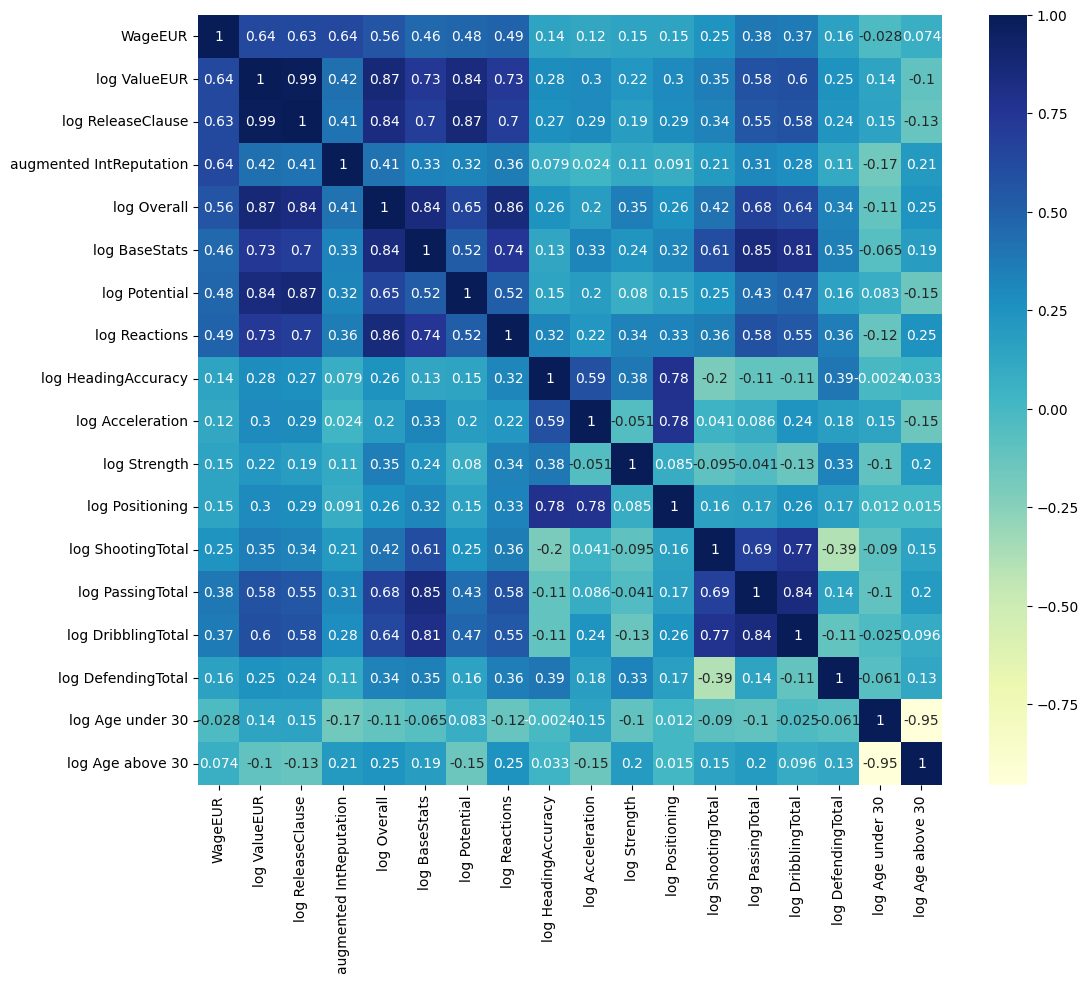

In [7]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor,annot=True,cmap='YlGnBu')
plt.show

In [8]:
# Recursive correlation pruning

df = df.drop(columns=['log ValueEUR', 'log Potential', 'log Reactions', 'log BaseStats',
'log Positioning', 'log PassingTotal', 'log DribblingTotal'])


In [9]:
df.head()

WageEUR  log ReleaseClause  augmented IntReputation  log Overall  \
0   195000          46.049201                       35     9.021719   
1   450000          46.730584                       28     9.021719   
2   420000          47.410418                       35     9.021719   
3   350000          47.770782                       28     9.021719   
4   230000          49.300137                       28     9.021719   

   log HeadingAccuracy  log Acceleration  log Strength  log ShootingTotal  \
0             4.248495          4.465908      4.219508           4.488636   
1             4.499810          4.369448      4.406719           4.477337   
2             4.510860          4.330733      4.465908           4.510860   
3             4.007333          4.330733      4.304065           4.477337   
4             4.276666          4.574711      4.330733           4.488636   

   log DefendingTotal  log Age under 30  log Age above 30  
0            3.526361          0.000000          0.795455  
1            3.663562          0.000000          0.772727  
2            3.784190          0.000000          0.750000  
3            4.158883          0.000000          0.704545  
4            3.583519          0.793103          0.000000

In [10]:
columns = df.columns
corr_list = []
column_needed = []
column_needed_2 = []
#y = fifa['WageEUR']
for col in columns:
    for col2 in columns:
        #if type(df[col][0]) == np.int64:
        corr = np.corrcoef(df[col],df[col2])
        corr_list.append(np.round(corr[0][1], 3))
        column_needed.append(col)
        column_needed_2.append(col2)
data = {"Column": column_needed, "Column2": column_needed_2, "Correlation Score": corr_list}
correlation_score = pd.DataFrame(data)
correlation_score = correlation_score[correlation_score['Correlation Score'] != 1.0]
correlation_score = correlation_score[correlation_score['Correlation Score'] > 0.7]
correlation_score.sort_values(by=['Correlation Score'], ascending=False)

Column            Column2  Correlation Score
14  log ReleaseClause        log Overall              0.838
34        log Overall  log ReleaseClause              0.838

In [11]:
# Fix multicollinearity 

#df['fixing'] =  df['log ReleaseClause'] * df['log Overall']
#df = df.drop(columns=['log ReleaseClause', 'log Overall'])

# Train test split
training, testing = train_test_split(df, test_size=0.2, random_state=41)
x_train = training.drop(labels='WageEUR',axis=1)
y_train = training[['WageEUR']]
x_test = testing.drop(labels='WageEUR',axis=1)
y_test = testing[['WageEUR']]

In [12]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model = lm.fit(x_train, y_train)
#model.predict(x_test)
model.score(x_train, y_train), model.score(x_test, y_test)

(0.5892864022786284, 0.5812078332144512)

In [13]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import train_test_split
rf = DecisionTreeRegressor(random_state = 42, criterion='friedman_mse', max_depth=6)
rf.fit(x_train, y_train)
rf.score(x_train, y_train), rf.score(x_test, y_test)

(0.834572815176102, 0.7509152794816211)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
rf = RandomForestRegressor(n_estimators = 200, random_state = 42, max_depth=6)
rf.fit(x_train, y_train)
rf.score(x_train, y_train), rf.score(x_test, y_test)

/tmp/ipykernel_190/4034169144.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


(0.8474291888425958, 0.8023505136274803)

In [15]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth=8, max_features=1.0)
rf.fit(x_train, y_train)#
rf.score(x_train, y_train), rf.score(x_test, y_test)

/tmp/ipykernel_190/3079581244.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)#


(0.8849376840032122, 0.806760067201416)

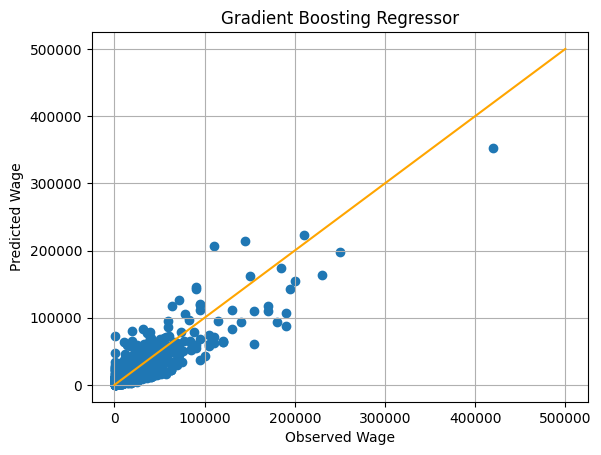

In [20]:
predictions = gb.predict(x_test)
x = list(range(500000))
y=list(range(500000))
plt.plot(x, y, color='orange')
plt.scatter(y_test, predictions)
plt.title('Gradient Boosting Regressor')
plt.xlabel('Observed Wage')
plt.ylabel('Predicted Wage')
plt.grid()

In [16]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(activation='identity', hidden_layer_sizes=(100, 100, 100, 100, 100), max_iter=400, random_state=42)
mlp.fit(x_train, y_train)
mlp.score(x_train, y_train), mlp.score(x_test, y_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.573303117806524, 0.5659635996883254)

In [17]:

from sklearn.svm import LinearSVR
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# model_1 = LinearRegression()
model_3 = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth=8, max_features=1.0)
# model_4 = MLPRegressor(activation='relu', hidden_layer_sizes=(10, 10, 10, 10, 10, 10), max_iter=200, random_state=42)
# model_5 = DecisionTreeRegressor(random_state = 42, criterion='friedman_mse', max_depth=6)
# model_6 = KNeighborsRegressor(n_neighbors=6)
model_9 = GradientBoostingRegressor(learning_rate=0.09, random_state=42, n_estimators=100, min_samples_split=3, max_depth=3)


estimators = [('rf', model_3), 
                ('gb', model_9)]
reg = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth=8, max_features=1.0))
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_stacking.py:865: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7644336121435521

In [18]:
model_3.fit(x_train, y_train)
model_9.fit(x_train, y_train)
predictions = (model_3.predict(x_test) + model_9.predict(x_test))/2
#predictions.reshape()

from sklearn.metrics import r2_score 
R_square = r2_score(predictions, y_test)
R_square

/tmp/ipykernel_266/2042153569.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_3.fit(x_train, y_train)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7467954893162967

In [19]:
mlp = MLPRegressor(activation='relu', hidden_layer_sizes=(10, 10, 10, 10, 10, 10), max_iter=200, random_state=42)
mlp.fit(x_train,y_train)
mlp.score(x_train,y_train), mlp.score(x_test,y_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.7393498369640772, 0.7464005162125436)

In [20]:
model_4 = MLPRegressor(activation='relu', hidden_layer_sizes=10, max_iter=50, random_state=42)
model_4.fit(x_train,y_train)
model_4.score(x_train,y_train), model_4.score(x_test,y_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.026403600185348042, 0.026511395117773895)

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(learning_rate=0.09, random_state=42, n_estimators=100, min_samples_split=3, max_depth=3)
gb.fit(x_train,y_train)
gb.score(x_train,y_train), gb.score(x_test,y_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.8542230942454884, 0.7988730767683051)

In [22]:
kn = KNeighborsRegressor(n_neighbors=10)
kn.fit(x_train,y_train)
kn.score(x_train,y_train), kn.score(x_test,y_test)

(0.8003330404840413, 0.7697781995930542)

In [23]:
ridge = RidgeCV()
ridge.fit(x_train,y_train)
ridge.score(x_train,y_train), ridge.score(x_test,y_test)

(0.5892846861479466, 0.58120400502198)

In [24]:
lasso = LassoCV()
lasso.fit(x_train,y_train)
lasso.score(x_train,y_train), lasso.score(x_test,y_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.5729613669947097, 0.5644378436394673)

In [25]:
import pandas as pd
 
data = [['Linear Regression',  69.87, 68.68], 
        ['Decision Tree Regression',  84.70, 73.33], 
        ['Random Forest Regression',  88.87, 80.66],
        ['MLP Regression',  74.25, 74.78],
        ['Gradient Boosting Regression', 85.85, 80.83],
        ['K-Neighbors Regression', 80.34, 76.21],
        ['Ridge Regression', 69.87, 68.69],
        ['LASSO Regression',57.14, 56.34]]
 
df = pd.DataFrame(data, columns=['Method', 'Training Accuracy(%)', 'Testing Accuracy(%)'])
df

Method  Training Accuracy(%)  Testing Accuracy(%)
0             Linear Regression                 69.87                68.68
1      Decision Tree Regression                 84.70                73.33
2      Random Forest Regression                 88.87                80.66
3                MLP Regression                 74.25                74.78
4  Gradient Boosting Regression                 85.85                80.83
5        K-Neighbors Regression                 80.34                76.21
6              Ridge Regression                 69.87                68.69
7              LASSO Regression                 57.14                56.34

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cc80a5ab-5a4e-4539-9976-15d1bdddd134' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>